# Phishing Detection

- **URL:** URL string
- **Label:** Binary variable ('bad' if the URL is malicious and 'good' otherwise)

In [1]:
#Importing necessary libraries
!pip install tldextract
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
from scipy.stats import randint, uniform
import random
from sklearn.model_selection import KFold, cross_val_score
import re
import tldextract
from urllib.parse import urlparse
from collections import Counter
from scipy.stats import entropy
warnings.filterwarnings("ignore")

In [29]:
# Import Data
df = pd.read_csv('phishing_site_urls.csv')

# Remove unnecessary whitespaces
df['URL'].str.strip()
df

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad
...,...,...
549341,23.227.196.215/,bad
549342,apple-checker.org/,bad
549343,apple-iclods.org/,bad
549344,apple-uptoday.org/,bad


## Special Characters in 'bad' URLs

***Special character:*** non-alphanumerical characters different from dots and slashes

- **Special Character:** this column contains special characters that appear in the bad URLs of the dataset.
- **Frequency in bad URLs:** number of bad URLs in which the special character appears.
- **Bad probability:** percentage of bad URLs in which the special character appears over all of the URLs in which the special character appears.
- **Danger Score:** the danger score of the URL is calculated as follows

$$\text{Danger score} = \text{Bad probability}\cdot \log(\text{Frequency in bad URLs})$$

In [30]:
# Initialize the special character tracker
special_chars = set()

# Corrected function to find special characters in a URL
def find_special_char(url):
    if isinstance(url, str):  # Ensure the input is a string
        special_chars_in_url = re.findall(r'[^a-zA-Z0-9]', url)  # Extract special characters
        special_chars.update(special_chars_in_url)  # Add to the global set
    return None

# Create an empty DataFrame for results
special_df = pd.DataFrame()

# Filter DataFrame for "bad" URLs
df_bad = df[df['Label'] == 'bad']

# Apply the function to the 'URL' column
df_bad['URL'].apply(find_special_char)

# Convert the set of special characters into a list
special_chars = list(special_chars)

# Remove '.' and '/' as they are common in URLs
special_chars.remove('.')
special_chars.remove('/')

# Populate the DataFrame with special characters
special_df['Special Character'] = special_chars

# Calculate frequency of special characters in "bad" URLs
special_df['Frequency in bad URLs'] = special_df['Special Character'].apply(
    lambda x: df_bad[df_bad['URL'].str.contains(re.escape(x), regex=True)].shape[0]
)

# Calculate probability of the special character being in "bad" URLs
special_df['Bad probability'] = special_df['Frequency in bad URLs'] / special_df['Special Character'].apply(
    lambda x: df[df['URL'].str.contains(re.escape(x), regex=True)].shape[0]
)

# Calculate a score for the special characters
special_df['Score'] = special_df['Bad probability'] * special_df['Frequency in bad URLs'].apply(math.log)

# Sort the DataFrame by score
special_df.sort_values(by='Score', ignore_index=True, ascending=False, inplace=True)

# Display the result
special_df

,Special Character,Frequency in bad URLs,Bad probability,Score
0,\,6363,0.966874,8.468132
1,;,11294,0.906639,8.460778
2,,1066,0.955197,6.659318
3,@,1809,0.882870,6.621990
4,',3591,0.774089,6.336839
...,...,...,...,...
167,ö,1,0.037037,0.000000
168,,1,0.032258,0.000000
169,,1,0.047619,0.000000
170,î,1,0.035714,0.000000


From now on we'll call the top ten characters of this list ***dangerous characters***. 

Top 10 Most Dangerous Special Characters: ['\\', ';', ' ', '@', "'", ':', '&', '>', '<', '=']


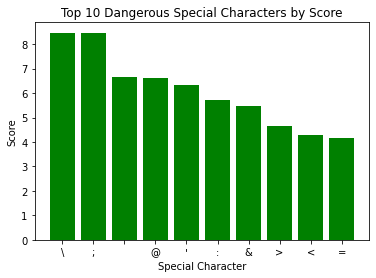

In [31]:
# Get the top 10 dangerous special characters
dangerous_chars = special_df['Special Character'].head(10).tolist()

# Display the dangerous characters
print("Top 10 Most Dangerous Special Characters:", dangerous_chars)

# Plot the top 10 special characters against their scores
plt.bar(dangerous_chars, special_df['Score'].head(10), color='green')
plt.xlabel('Special Character')
plt.ylabel('Score')
plt.title('Top 10 Dangerous Special Characters by Score')
plt.show()


## TLDs in 'bad' URLs

In [32]:
# Initialize the TLD DataFrame
TLD_df = pd.DataFrame()

# Extract TLDs (Top-Level Domains) from the 'URL' column in df
TLD_list = df[df['Label'] == 'bad']['URL'].apply(lambda x: tldextract.extract(x).suffix).unique()

# Convert the TLD list to a DataFrame
TLD_df['TLD'] = pd.Series(TLD_list)

# Calculate frequency of each TLD in bad URLs
TLD_df['Frequency in bad URLs'] = TLD_df['TLD'].apply(
    lambda x: df[df['Label'] == 'bad']['URL'].str.contains(r'\.' + re.escape(x) + r'$', regex=True).sum()
)

# Calculate the probability of a TLD being in bad URLs
TLD_df['Bad probability'] = TLD_df['Frequency in bad URLs'] / TLD_df['TLD'].apply(
    lambda x: df['URL'].str.contains(r'\.' + re.escape(x) + r'$', regex=True).sum()
)

# Calculate a score for each TLD
TLD_df['Score'] = TLD_df['Bad probability'] * TLD_df['Frequency in bad URLs'].apply(lambda freq: math.log(freq) if freq > 0 else 0)

# Sort the DataFrame by score
TLD_df.sort_values(by='Score', ignore_index=True, ascending=False, inplace=True)

# Display the TLD DataFrame
TLD_df


,TLD,Frequency in bad URLs,Bad probability,Score
0,com,2722,0.930280,7.357700
1,net,243,0.949219,5.214117
2,,136,0.985507,4.841457
3,it,135,0.985401,4.833665
4,top,87,1.000000,4.465908
...,...,...,...,...
601,moe,0,NaN,NaN
602,wiki,0,NaN,NaN
603,CO.UK,0,NaN,NaN
604,US,0,NaN,NaN


Top 10 Most Dangerous TLDs: ['com', 'net', '', 'it', 'top', 'sh', 'pl', 'ru', 'info', 'br']


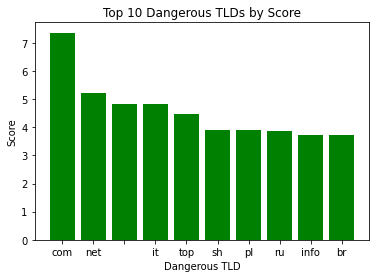

In [33]:
# Get the top 10 dangerous special characters
dangerous_TLDs = TLD_df['TLD'].head(10).tolist()

# Display the dangerous characters
print("Top 10 Most Dangerous TLDs:", dangerous_TLDs)

# Plot the top 10 special characters against their scores
plt.bar(dangerous_TLDs, TLD_df['Score'].head(10), color='green')
plt.xlabel('Dangerous TLD')
plt.ylabel('Score')
plt.title('Top 10 Dangerous TLDs by Score')
plt.show()

## Feature Extraction

We'll extract the following features from the raw data:

- **URL length:** total length of the URL string
- **Number of dots:** number of dots in the URL
- **Number of slashes:**  number of slashes in the URL
- **Percentage of numerical characters:** percentage of numerical characters in the URL.
- **Dangerous characters:** True = dangerous character in the URL, False = otherwise
- **Dangerous TLD:** True = TLD of the URL is dangerous, False = otherwise)
- **IP address:** True = IP address in the URL, False = otherwise).
- **Domain name length:** length of the main domain part
- **Suspicious keywords:** True = suspicious keywords in the domain

    [secure, account, update, login, verify ,signin, bank,notify, click, inconvenient]
                      
     A reference for this list is *D. Ranganayakulu, Chellappan C.,Detecting Malicious URLs in E-mail – An Implementation, 2013, AASRI Procedia*.

- **Repetitions:** True = domain contains a substring of three identical characters, False = otherwise
- **Redirections:** True = there is a // in a position higher than 7 and False otherwise (7 is chosen in order to avoid including the (generally safe) redirection of https:// and similar cases)


In [34]:
# URL length
df['URL length'] = df['URL'].apply(len)

# Number of dots
df['Number of dots'] = df['URL'].str.count(r'\.')

# Number of slashes
df['Number of slashes'] = df['URL'].str.count(r'/')

# Percentage of numerical characters
df['Percentage of numerical characters'] = df['URL'].apply(
    lambda x: sum(c.isdigit() for c in x) / len(x) if len(x) > 0 else 0
)

# Dangerous characters
df['Dangerous characters'] = df['URL'].apply(
    lambda x: any(char in x for char in dangerous_chars)
)

# Dangerous TLD
df['Dangerous TLD'] = df['URL'].apply(
    lambda x: tldextract.extract(x).suffix in dangerous_TLDs
)

# IP Address
ip_pattern = r'[0-9]+(?:\.[0-9]+){3}'
df['IP Address'] = df['URL'].str.contains(ip_pattern)

# Domain name length
df['Domain name length'] = df['URL'].apply(
    lambda x: len(tldextract.extract(x).domain)
)

# Suspicious keywords
suspicious_keywords = ['secure', 'account', 'update', 'login', 'verify', 'signin', 'bank', 'notify', 'click', 'inconvenient']

df['Suspicious keywords'] = df['URL'].apply(
    lambda x: any(word in x.lower() for word in suspicious_keywords)
)

# Repetitions
df['Repetitions'] = df['URL'].apply(
    lambda x: bool(re.search(r'(.)\1{2,}', tldextract.extract(x).domain))
)

# Redirections
def has_redirection(url):
    last_double_slash = url.rfind('//')
    return last_double_slash > 7  # Check if "//" appears after the protocol.

df['Redirections'] = df['URL'].apply(has_redirection)

# Print the new dataset
df


,URL,Label,URL length,Number of dots,Number of slashes,Percentage of numerical characters,Dangerous characters,Dangerous TLD,IP Address,Domain name length,Suspicious keywords,Repetitions,Redirections
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,225,6,10,0.257778,True,True,False,6,True,False,False
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,81,5,4,0.012346,True,True,False,7,False,False,False
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,177,7,11,0.265537,False,True,False,12,True,False,False
3,mail.printakid.com/www.online.americanexpress....,bad,60,6,2,0.000000,False,True,False,9,False,False,False
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,116,1,10,0.181034,False,True,False,15,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
549341,23.227.196.215/,bad,15,3,1,0.733333,False,True,True,14,False,False,False
549342,apple-checker.org/,bad,18,1,1,0.000000,False,False,False,13,False,False,False
549343,apple-iclods.org/,bad,17,1,1,0.000000,False,False,False,12,False,False,False
549344,apple-uptoday.org/,bad,18,1,1,0.000000,False,False,False,13,False,False,False


## Exploratory Data Analysis and Feature Engineering

We standardize numerical features (except the **Percentage of numerical characters**).

In [35]:
scaler = StandardScaler()

num_columns = ['URL length', 'Number of dots', 'Number of slashes', 'Domain name length']

df[num_columns] = scaler.fit_transform(df[num_columns])

In [36]:
# Create flags for boolean and target label
df['IP Address'] = df['IP Address'].astype(int)
df['Suspicious keywords'] = df['Suspicious keywords'].astype(int)
df['Repetitions'] = df['Repetitions'].astype(int)
df['Redirections'] = df['Redirections'].astype(int)
df['Dangerous characters'] = df['Dangerous characters'].astype(int)
df['Dangerous TLD'] = df['Dangerous TLD'].astype(int)
df['Label'] = (df['Label'] == 'good').astype(int)

# Drop URL col
df.drop(columns=['URL'], inplace=True)

df

,Label,URL length,Number of dots,Number of slashes,Percentage of numerical characters,Dangerous characters,Dangerous TLD,IP Address,Domain name length,Suspicious keywords,Repetitions,Redirections
0,0,3.923264,2.599770,4.734477,0.257778,1,1,0,-0.799148,1,0,0
1,0,0.681338,1.939541,0.974386,0.012346,1,1,0,-0.582612,0,0,0
2,0,2.842622,3.259998,5.361159,0.265537,0,1,0,0.500071,1,0,0
3,0,0.208557,2.599770,-0.278978,0.000000,0,1,0,-0.149538,0,0,0
4,0,1.469306,-0.701371,4.734477,0.181034,0,1,0,1.149681,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
549341,0,-0.804544,0.619085,-0.905660,0.733333,0,1,1,0.933144,0,0,0
549342,0,-0.737004,-0.701371,-0.905660,0.000000,0,0,0,0.716608,0,0,0
549343,0,-0.759518,-0.701371,-0.905660,0.000000,0,0,0,0.500071,0,0,0
549344,0,-0.737004,-0.701371,-0.905660,0.000000,0,0,0,0.716608,0,0,0


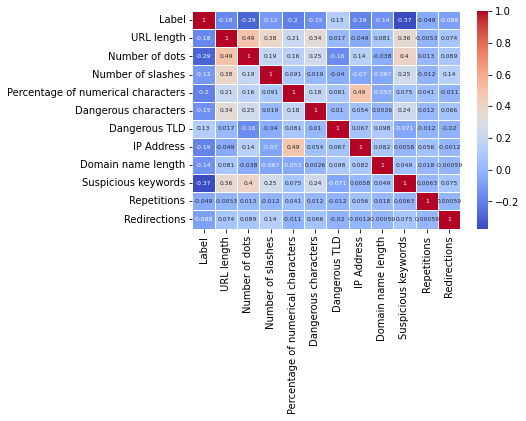

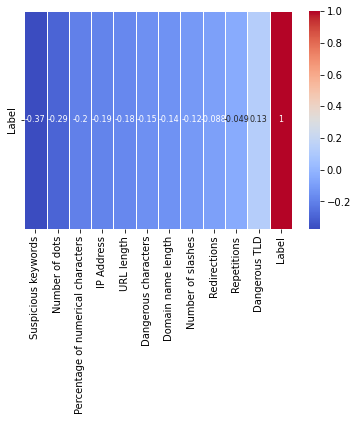

                                       Label
Suspicious keywords                -0.371093
Number of dots                     -0.293474
Percentage of numerical characters -0.204039
IP Address                         -0.191832
URL length                         -0.177295
Dangerous characters               -0.146440
Domain name length                 -0.144416
Number of slashes                  -0.118405
Redirections                       -0.088167
Repetitions                        -0.049215
Dangerous TLD                       0.127798
Label                               1.000000


In [37]:
# Heatmap
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 6})
plt.show()
sns.heatmap(corr_matrix[['Label']].sort_values(by='Label').T, annot=True, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 8})
plt.show()
print(corr_matrix[['Label']].sort_values(by='Label'))

## Train-Test Split

In [38]:
# Ensure equal representation in the data
df['Label'].value_counts(normalize=True)

1    0.715258
0    0.284742
Name: Label, dtype: float64

In [39]:
# Undersample
n_samples = df['Label'].value_counts()[0]
df_good = df[df['Label'] == 1]
df_bad = df[df['Label'] == 0]
df_goodsample = df_good.sample(n=n_samples, random_state=22)
df_goodmissing = df_good.drop(df_goodsample.index)

df = pd.concat([df_bad, df_goodsample], ignore_index=True)

df

,Label,URL length,Number of dots,Number of slashes,Percentage of numerical characters,Dangerous characters,Dangerous TLD,IP Address,Domain name length,Suspicious keywords,Repetitions,Redirections
0,0,3.923264,2.599770,4.734477,0.257778,1,1,0,-0.799148,1,0,0
1,0,0.681338,1.939541,0.974386,0.012346,1,1,0,-0.582612,0,0,0
2,0,2.842622,3.259998,5.361159,0.265537,0,1,0,0.500071,1,0,0
3,0,0.208557,2.599770,-0.278978,0.000000,0,1,0,-0.149538,0,0,0
4,0,1.469306,-0.701371,4.734477,0.181034,0,1,0,1.149681,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
312839,1,-0.444330,-0.701371,-0.905660,0.000000,0,0,0,-0.582612,0,0,0
312840,1,-0.534384,-0.041143,-0.278978,0.000000,0,0,0,-0.149538,0,0,0
312841,1,-0.354277,-0.041143,0.347704,0.000000,0,1,0,-1.448758,0,0,0
312842,1,-0.241710,-0.041143,-0.905660,0.000000,0,1,0,-0.366075,0,0,0


In [40]:
# Divide feats
y = df['Label']
df.drop(columns=['Label'], inplace=True)

We split the data into training set and test set. We also add the 'good' URL we discarded previously to the test set.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=22)

y_goodmissing = df_goodmissing['Label']
df_goodmissing.drop(columns=['Label'], inplace=True)

# Merging X_test and X_goodmissing

X_test = pd.concat([X_test, df_goodmissing], axis=0)

# Merging y_test and y_goodmissing

y_test = pd.concat([y_test, y_goodmissing], axis=0)

## Construction of a ML model

In [42]:
# Create Model with 3 fold cv
kf = KFold(n_splits=3, shuffle=True, random_state=22)

rf_model = RandomForestClassifier(random_state=22)
print(cross_val_score(rf_model, X_train, y_train, cv=kf, scoring='accuracy').mean())

0.8664309259814204


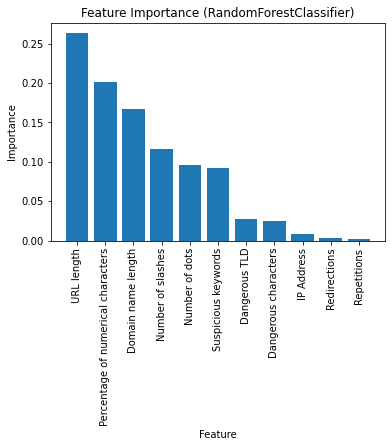

In [43]:
rf_model.fit(X_train, y_train)
importances = rf_model.feature_importances_
feature_names = df.columns 
indices = np.argsort(importances)[::-1]

plt.title('Feature Importance (RandomForestClassifier)')
plt.bar(range(df.shape[1]), importances[indices], align='center')
plt.xticks(range(df.shape[1]), feature_names[indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()


In [44]:
probs = rf_model.predict_proba(X_test)
print("Predicted probabilities for phishing class (1):", probs[:, 1])

Predicted probabilities for phishing class (1): [1.      0.01    0.379   ... 0.14    1.      0.82525]


In [18]:
# Test the model
from sklearn.metrics import accuracy_score

rf_pred = rf_model.predict(X_test)

print(accuracy_score(y_test, rf_pred))

0.8749995820390476


In [45]:
# Evaluate the model
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")


Model Accuracy: 87.50%


In [47]:
import numpy as np
from sklearn.metrics import accuracy_score

# Function to extract features from a URL dynamically
def extract_url_features(url):
    import re
    from collections import Counter
    import tldextract
    from urllib.parse import urlparse

    # Features to be extracted
    features = {
        "URL length": len(url),
        "Number of dots": url.count('.'),
        "Number of slashes": url.count('/'),
        "Percentage of numerical characters": sum(c.isdigit() for c in url) / len(url) if len(url) > 0 else 0,
        "Dangerous characters": any(char in url for char in dangerous_chars),
        "Dangerous TLD": tldextract.extract(url).suffix in dangerous_TLDs,
        "IP Address": bool(re.search(r'[0-9]+(?:\.[0-9]+){3}', url)),
        "Domain name length": len(tldextract.extract(url).domain),
        "Suspicious keywords": any(word in url.lower() for word in suspicious_keywords),
        "Repetitions": bool(re.search(r'(.)\1{2,}', tldextract.extract(url).domain)),
        "Redirections": url.rfind('//') > 7,  # Check for multiple "//" after protocol
    }
    return np.array(list(features.values())).reshape(1, -1)

# Function to predict phishing or safe for a given URL with threshold adjustment
def predict_url(url, model, threshold=0.3):
    # Extract features dynamically
    features = extract_url_features(url)
    
    # Predict probabilities using the trained model
    probs = model.predict_proba(features)
    print(f"Predicted probabilities for phishing class (1): {probs[0][1]}")  # Debugging output

    # Determine result based on threshold
    return "Phishing" if probs[0][1] >= threshold else "Safe"

# Function to evaluate the model accuracy on a test set
def evaluate_model(model, X_test, y_test, threshold=0.3):
    # Predict probabilities on the test set
    probs = model.predict_proba(X_test)[:, 1]
    
    # Apply threshold to classify
    y_pred = (probs >= threshold).astype(int)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy at threshold {threshold}: {accuracy * 100:.2f}%")
    return accuracy

# Example usage
example_url = "http://example.com/login"
print(f"Prediction for URL '{example_url}': {predict_url(example_url, rf_model, threshold=0.3)}")

# Evaluate the model
evaluate_model(rf_model, X_test, y_test, threshold=0.3)


Predicted probabilities for phishing class (1): 0.0
Prediction for URL 'http://example.com/login': Safe
Model Accuracy at threshold 0.3: 92.30%


0.9230349983783115

In [52]:
# Example usage
example_url = "https://sit.instructure.com/courses/76605/files/13685285?module_item_id=2247117"
print(f"Prediction for URL '{example_url}': {predict_url(example_url, rf_model, threshold=0.1)}")

Predicted probabilities for phishing class (1): 0.08
Prediction for URL 'https://sit.instructure.com/courses/76605/files/13685285?module_item_id=2247117': Safe


In [51]:
# Example usage
example_url = "www.google-search.com"
print(f"Prediction for URL '{example_url}': {predict_url(example_url, rf_model, threshold=0.1)}")


Predicted probabilities for phishing class (1): 0.14
Prediction for URL 'www.google-search.com': Phishing
